# **Natural Language Processing with Disaster Tweets**



# ***1. Import Required Libraries***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report


#  ***Load the Dataset***

In [2]:
# Load the datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Display basic information
print(train_data.info())
print(test_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


#  ***Explore Label Distribution***

<ipython-input-3-5d13a64da6c7>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_distribution.index, y=label_distribution.values, palette="viridis")


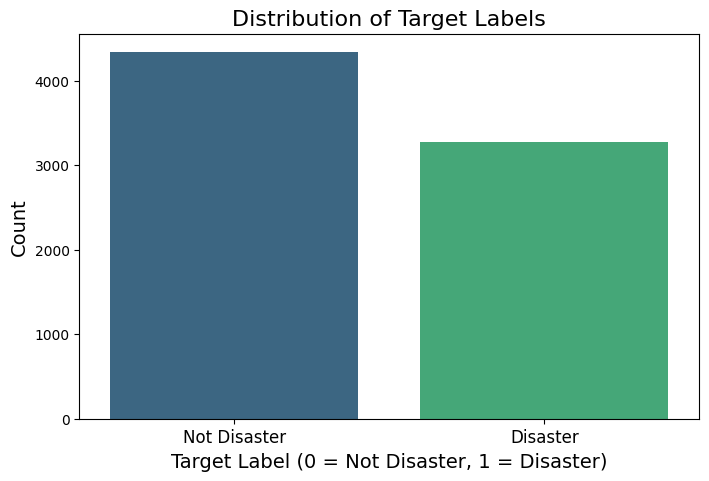

In [3]:
# Analyze the target label distribution
label_distribution = train_data['target'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=label_distribution.index, y=label_distribution.values, palette="viridis")
plt.title("Distribution of Target Labels", fontsize=16)
plt.xlabel("Target Label (0 = Not Disaster, 1 = Disaster)", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Not Disaster', 'Disaster'], fontsize=12)
plt.show()


# ***Preprocess the Text Data***

In [4]:
# Function to clean text
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)    # Remove mentions
    text = re.sub(r'#', '', text)       # Remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = text.strip()  # Remove leading/trailing whitespace
    return text

# Apply the function to the text column
train_data['cleaned_text'] = train_data['text'].apply(clean_text)
test_data['cleaned_text'] = test_data['text'].apply(clean_text)

# Display a few cleaned examples
print(train_data[['text', 'cleaned_text']].head())


                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                        cleaned_text  
0  our deeds are the reason of this earthquake ma...  
1              forest fire near la ronge sask canada  
2  all residents asked to shelter in place are be...  
3  people receive wildfires evacuation orders in ...  
4  just got sent this photo from ruby alaska as s...  


#  ***Prepare Data for Modeling***

In [5]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_data['cleaned_text'], train_data['target'], test_size=0.2, random_state=42)

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Transform text data
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(test_data['cleaned_text'])


# ***Train a Basic Model***

In [6]:
# Initialize Logistic Regression
model = LogisticRegression()

# Train the model
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_val_tfidf)

# Evaluate the model
print("F1 Score:", f1_score(y_val, y_pred))
print(classification_report(y_val, y_pred))


F1 Score: 0.7552213868003341
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       874
           1       0.82      0.70      0.76       649

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



# ***Make Predictions for Test Data***

In [7]:
# Predict for test set
test_predictions = model.predict(X_test_tfidf)

# Prepare the submission file
submission = pd.DataFrame({'id': test_data['id'], 'target': test_predictions})
submission.to_csv('submission.csv', index=False)


In [8]:
# export submission file
submission.to_csv('submission.csv', index=False)

# **2. Sentiment Analysis with** TextBlob

In [9]:
from textblob import TextBlob

# Function to get sentiment polarity
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity  # Polarity ranges from -1 (negative) to 1 (positive)

# Apply sentiment analysis on the cleaned text
train_data['sentiment_polarity'] = train_data['cleaned_text'].apply(get_sentiment)
test_data['sentiment_polarity'] = test_data['cleaned_text'].apply(get_sentiment)

# Display some examples
print(train_data[['cleaned_text', 'sentiment_polarity']].head())


                                        cleaned_text  sentiment_polarity
0  our deeds are the reason of this earthquake ma...             0.00000
1              forest fire near la ronge sask canada             0.10000
2  all residents asked to shelter in place are be...            -0.01875
3  people receive wildfires evacuation orders in ...             0.00000
4  just got sent this photo from ruby alaska as s...             0.00000


# **Categorize Sentiment**-

### ***Convert the polarity into discrete categories: Positive, Negative, and Neutral.***

In [10]:
# Function to categorize sentiment
def categorize_sentiment(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply categorization
train_data['sentiment_category'] = train_data['sentiment_polarity'].apply(categorize_sentiment)
test_data['sentiment_category'] = test_data['sentiment_polarity'].apply(categorize_sentiment)

# Display sentiment categories
print(train_data[['cleaned_text', 'sentiment_category']].head())


                                        cleaned_text sentiment_category
0  our deeds are the reason of this earthquake ma...            Neutral
1              forest fire near la ronge sask canada           Positive
2  all residents asked to shelter in place are be...           Negative
3  people receive wildfires evacuation orders in ...            Neutral
4  just got sent this photo from ruby alaska as s...            Neutral


#  **Visualize Sentiment Distribution**

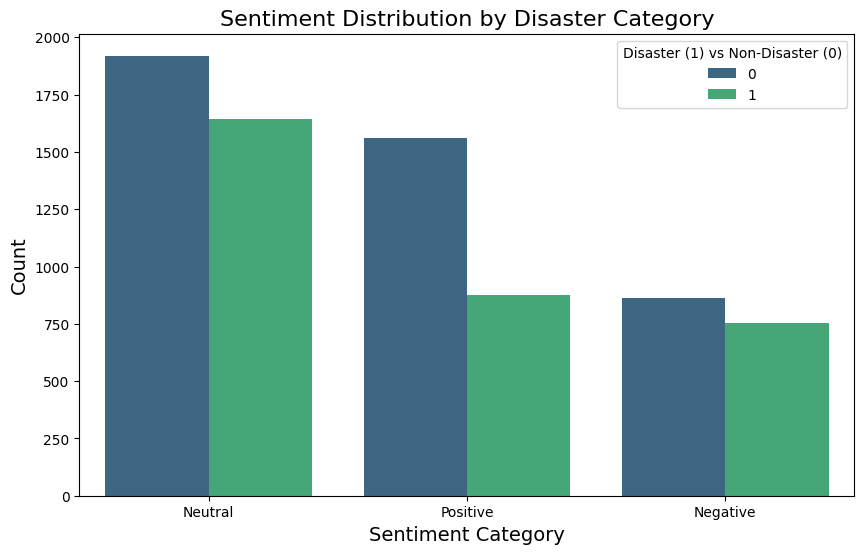

In [11]:
# Plot sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=train_data, x='sentiment_category', hue='target', palette='viridis')
plt.title("Sentiment Distribution by Disaster Category", fontsize=16)
plt.xlabel("Sentiment Category", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(title="Disaster (1) vs Non-Disaster (0)", loc='upper right')
plt.show()


# **Incorporate Sentiment as a Feature**

In [16]:
!pip install -q scikit-learn pandas numpy

# Assuming 'train_data' contains 'cleaned_text', 'target', and 'sentiment_polarity' columns
# Assuming 'test_data' contains 'cleaned_text' and 'sentiment_polarity' columns

# Split data into training and validation sets
X = train_data['cleaned_text']
y = train_data['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed

# Create and train Logistic Regression model with sentiment features
model = LogisticRegression()

# 1. Transform text data using TF-IDF
X_train_text = tfidf.fit_transform(X_train)
X_val_text = tfidf.transform(X_val)

# 2. Get sentiment polarity for training and validation sets
X_train_sentiment = train_data.loc[X_train.index, 'sentiment_polarity'].values.reshape(-1, 1)
X_val_sentiment = train_data.loc[X_val.index, 'sentiment_polarity'].values.reshape(-1, 1)

# 3. Combine text features and sentiment features
X_train_combined = np.hstack((X_train_text.toarray(), X_train_sentiment))
X_val_combined = np.hstack((X_val_text.toarray(), X_val_sentiment))

# 4. Train the model
model.fit(X_train_combined, y_train)

# 5. Make predictions and evaluate
y_pred = model.predict(X_val_combined)
print("F1 Score with Sentiment Features:", f1_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

# Now you can apply this to the test data:
X_test_text = tfidf.transform(test_data['cleaned_text'])
X_test_sentiment = test_data['sentiment_polarity'].values.reshape(-1, 1)
X_test_combined = np.hstack((X_test_text.toarray(), X_test_sentiment))

# Make predictions on the test data
test_predictions = model.predict(X_test_combined)


F1 Score with Sentiment Features: 0.7562604340567612
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       874
           1       0.83      0.70      0.76       649

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.81      1523



# ***3. Disaster Tweets Classification***

In [17]:
# Function to clean text
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)    # Remove mentions
    text = re.sub(r'#', '', text)       # Remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text.strip()

# Apply cleaning to the text
train_data['cleaned_text'] = train_data['text'].apply(clean_text)
test_data['cleaned_text'] = test_data['text'].apply(clean_text)


# ***Split the Data***

In [18]:
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_data['cleaned_text'], train_data['target'], test_size=0.2, random_state=42
)


# **Convert Text to Numerical Features**

In [19]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Transform training and validation data
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(test_data['cleaned_text'])


# **Train the Model**

In [20]:
# Initialize the model
model = LogisticRegression()

# Train the model
model.fit(X_train_tfidf, y_train)

# Predict on validation data
y_pred_val = model.predict(X_val_tfidf)

# Evaluate the model
print("F1 Score (Validation):", f1_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))


F1 Score (Validation): 0.7552213868003341
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       874
           1       0.82      0.70      0.76       649

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



# ***Predict on Test Data***

In [21]:
# Predict on the test dataset
test_predictions = model.predict(X_test_tfidf)

# Prepare the submission file
submission = pd.DataFrame({'id': test_data['id'], 'target': test_predictions})
submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'.")


Submission file saved as 'submission.csv'.
